<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> We need to add the deterministic process to the training data. We need to find out how to implement lagged variables, we need to discuss whether,we should use future values as well. 

<ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol>

In [1004]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

In [898]:
df = pd.read_csv('Preprocessed_data.csv')


df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date', 'Salmon_exp_price'], axis=1, inplace=True)

In [954]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

In [955]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h1> Trying

In [ ]:
fourier  =  CalendarFourier(freq='A',  order=4)
fourier  =  CalendarFourier(freq='A',  order=4)
fourier  =  CalendarFourier(freq='A',  order=4)

In [1042]:
def det_process(X):
    fourier0  =  CalendarFourier(freq='A',  order=3)
    fourier1  =  CalendarFourier(freq='6M',  order=3)
    fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    new_X = pd.concat([X,dp], axis=1)
    return new_X
timeDummy = FunctionTransformer(func=det_process)


def log_transformation(X):
    X = np.log1p(X)
    return X
loger = FunctionTransformer(func=log_transformation)

normalizer = StandardScaler()

def reshaper(X):
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])    
    return   X_reshaped
reshape = FunctionTransformer(func=reshaper)
log_cols = ['FX_EURONOK']

from sklearn.compose import ColumnTransformer
engineering = ColumnTransformer(
    transformers=[
        ('loger', loger, log_cols)      
], remainder='passthrough')

mod = keras.Sequential([
    layers.LSTM(2, input_shape=(1,74)),
    layers.Dropout(0.4),
    layers.Dense(8, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
mod.compile(optimizer='adam',
              loss='mae')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

popo = Pipeline(steps=[
    ('det', timeDummy),
    ('Col_spec', engineering),
    ('norm', normalizer),
    ('res', reshape),
    # ('lstm', model)
])

In [1047]:
X_train_preprocessed =popo.fit_transform(X_train)
X_val_preprocessed = popo.transform(X_val)
X_test_preprocessed = popo.transform(X_test)

In [1034]:
X_train_preprocessed.shape

(960, 1, 74)

In [1048]:
mod.fit(X_train_preprocessed, y_train, 
          epochs=150, batch_size=50,
          validation_data=[X_val_preprocessed, y_val]
          )

Epoch 1/150
 1/20 [>.............................] - ETA: 0s - loss: 2722.9722

20/20 [==============================] - 0s 5ms/step - loss: 3229.1489 - val_loss: 12199.6846
Epoch 2/150
20/20 [==============================] - 0s 4ms/step - loss: 3190.9553 - val_loss: 12099.3809
Epoch 3/150
20/20 [==============================] - 0s 4ms/step - loss: 3125.1697 - val_loss: 12128.4199
Epoch 4/150
20/20 [==============================] - 0s 3ms/step - loss: 3148.6514 - val_loss: 12103.2500
Epoch 5/150
20/20 [==============================] - 0s 3ms/step - loss: 3326.4993 - val_loss: 12171.7588
Epoch 6/150
20/20 [==============================] - 0s 3ms/step - loss: 2986.6489 - val_loss: 12204.5596
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 3210.2556 - val_loss: 12297.5205
Epoch 8/150
20/20 [==============================] - 0s 3ms/step - loss: 3111.9221 - val_loss: 12462.1348
Epoch 9/150
20/20 [==============================] - 0s 3ms/step - loss: 3181.1567 - val_loss: 12460.1104
Epoch 10/150
20/20 [==============================] - 0s 8

30/30 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 0s/step


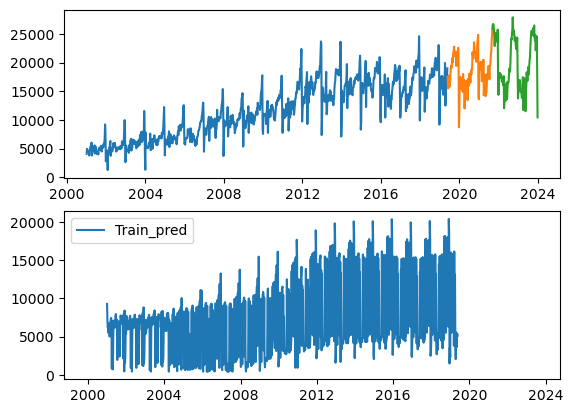

In [1052]:
train_pred = mod.predict(X_train_preprocessed)
val_pred = mod.predict(X_test_preprocessed)
# test_pred = mod.predict(X_test_preprocessed)


fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')

ax[1].plot(X_train.index, train_pred, label='Train_pred')
ax[1].set_xlim(10500,20000)
# ax[1].plot(X_val.index, test_pred, label='Test_pred')

plt.legend()
plt.show()

In [1028]:
from sklearn.metrics import root_mean_squared_error as RMSE

In [1031]:
RMSE(train_pred, y_train)

4512.313952140112

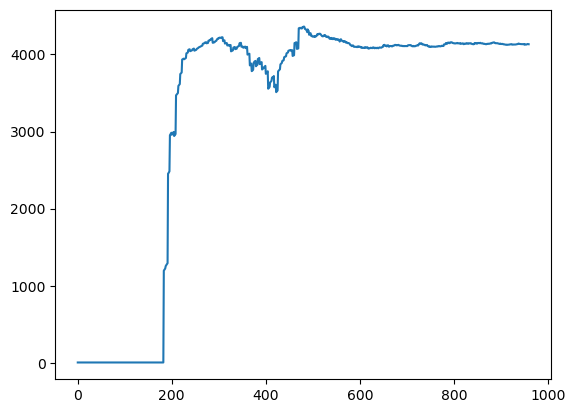

In [879]:
plt.plot(popp)

In [890]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [891]:
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)